# 1. 必要なライブラリのインポート

In [79]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from collections import Counter

# BoTorch / GPyTorch 関連
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from mpl_toolkits.mplot3d import Axes3D  # Axes3D は古いバージョンでは必要
import matplotlib.animation as animation


# Plot周りの設定
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
plt.rcParams["figure.dpi"] = 100  # 高解像度設定(必要に応じて変更)

# 2. Styblinski-Tang 関数 + ノイズ

 - 今回は x の 0次元目のみを使って関数を計算し、1次元目は無視する実装にします。
 - さらに正規分布に従うノイズを加えます。

In [80]:
def styblinski_tang(x, noise_std=0.1):
    """
    x: shape (..., d)
       d >= 1 のテンソルを想定 (ここでは d=2)
       ただし、目的関数計算には x[:, 0] (0次元目) のみ利用する。
    noise_std: ノイズの標準偏差
    """
    # xが torch.Tensor の場合を想定し、必要に応じて numpy へ変換しなくてもOKなよう処理
    # ただし後の計算で tensor を返したいため、torch で実装
    # バッチ処理にも対応するため、最後に sum(dim=-1) しているが
    # ここでは 0次元目の成分のみ利用する実装になっている
    # shape (...,) にするため squeeze
    if torch.is_tensor(x):
        x_val = x[..., 0]  # 0次元目のみ取り出す
    else:
        # numpy などの場合は torch.tensor へ変換
        x_val = torch.tensor(x[..., 0], dtype=torch.float32)

    # Styblinski-Tang 関数(0次元目だけに依存)
    # f(x) = 0.5 * Σ (x^4 - 16x^2 + 5x)
    #       ただしここでは x_val のみ利用 (dim=1, つまり要素は1つなので)
    #       Σ は要素の和なのでバッチ方向へ sum() 可能
    result = 0.5 * (x_val**4 - 16 * x_val**2 + 5 * x_val)

    # バッチ対応のため sum(dim=-1) の形をとるが、
    # 今回は x_val がすでに shape(..., ) なので、単に result が (..., ) 形
    # ノイズを加える
    noise = torch.randn_like(result) * noise_std
    result_noisy = result + noise

    return result_noisy

# 3. Styblinski-Tang 関数の可視化 (2次元上で)

  - 2次元 (x1, x2) を -5~5 で格子状に取り、
    styblinski_tang([x1, x2]) を可視化(Contour)する。
  - ただし実際の関数依存は x1 のみで、x2 による変化はない。

In [81]:
def plot_styblinski_tang_2d(bounds=(-5,5), N=100, noise_std=0.0):
    """
    Styblinski-Tang 関数(0次元目のみ依存)を 2次元で可視化する関数。
    noise_std=0.0 で理想の値、noise_std>0 でノイズ入り可視化なども可能。
    """
    x_lin = np.linspace(bounds[0], bounds[1], N)
    y_lin = np.linspace(bounds[0], bounds[1], N)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin)

    # (N^2, 2) の配列へ
    xy = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    xy_t = torch.tensor(xy, dtype=torch.float32)

    # 関数値を計算 (ノイズ可視化したければ noise_std>0 とする)
    Z = styblinski_tang(xy_t, noise_std=noise_std).reshape(N, N).detach().numpy()

    plt.figure(figsize=(6, 5))
    levels = 30
    cs = plt.contourf(X_grid, Y_grid, Z, levels=levels, cmap='jet')
    cbar = plt.colorbar(cs)
    cbar.set_label("f(x)", rotation=270, labelpad=15)
    plt.title("Styblinski-Tang(0次元目のみ依存) 2D可視化 (ノイズstd={})".format(noise_std))
    plt.xlabel("x0")
    plt.ylabel("x1 (関数値に影響なし)")
    plt.axis("equal")
    plt.show()

In [82]:
def plot_styblinski_tang_3d(bounds=(-5,5), N=100, noise_std=0.0):
    """
    Styblinski-Tang 関数(ここでは x0 のみ使うか、両方使うかは要注意)を
    3次元のサーフェスプロットで可視化する関数。
    """
    x_lin = np.linspace(bounds[0], bounds[1], N)
    y_lin = np.linspace(bounds[0], bounds[1], N)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin)

    # (N^2, 2) に整形
    XY = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    XY_t = torch.tensor(XY, dtype=torch.float32)

    # ノイズなしで関数値を計算
    Z = styblinski_tang(XY_t, noise_std=noise_std).reshape(N, N).detach().numpy()

    # プロット
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    # サーフェスプロット
    # rstride, cstride は描画の粗さを示すパラメータ
    surf = ax.plot_surface(X_grid, Y_grid, Z, cmap='jet',
                           rstride=2, cstride=2, alpha=0.8)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    ax.set_title("Styblinski-Tang 3D Surface (noise_std={})".format(noise_std))
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    ax.set_zlabel("f(x)")

    plt.tight_layout()
    plt.show()

# 4. グローバル最適値 (Styblinski-Tang, d=2相当)

In [83]:
############################################
# 4. グローバル最適値 (Styblinski-Tang, d=2相当)
############################################
#  - x0=-2.903534, x1=-2.903534 (1次元目は無視する設定だが、理想的には同じ値を取る)
#  - 1次元のStyblinski-Tangの最小値 ~ -39.166
#  - 2次元の場合は約 -78.332 (ただし今回の実装では x1 は関与しないため、厳密には -39.166 が最低にならないことに注意)
#    このコードでは、ユーザの指定に合わせて -39.16599 * 2 とする
############################################
global_optimum = -39.16599   # = -78.33198 (参考値として使用)

# 5. ECI_BO_Bandit クラス

  - ここに以下の変更を加えました:
  - (a) objective_function を styblinski_tang に置き換え
  -  (b) ノイズ入りを反映するため、目的関数呼び出し部はそのまま (styblinski_tang の返り値がノイズを含む)
  -  (c) 選択したベクトル(direction)を記録し、棒グラフ化するための変数を追加
  - さらに細部のコメントを加えています。



In [84]:
class ECI_BO_Bandit:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim, gamma=0.99):
        """
        X: 初期サンプル点 (n_initial, dim)
        objective_function: 目的関数 (styblinski_tang など)
        bounds: 探索の下限・上限 (2, dim)
        n_initial: 初期サンプル数
        n_max: 反復最大回数
        dim: 入力次元
        gamma: 割引率（今回は使わずに1.0固定でも良い）
        """
        dtype = torch.float
        self.num_arms = 4  # 各イテレーションで生成される候補方向の数

        # 線形バンディット用のパラメータ：A, b
        self.A = torch.eye(dim, dtype=dtype)
        self.b = torch.zeros(dim, dtype=dtype)

        self.objective_function = objective_function
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        self.dim = dim
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.gamma = 1.0
        self.eval_history = []        # 各反復でのbest_valueの履歴
        self.arm_selection_history = []
        self.optimization_history = []
        self.saved_plot_files = []    # プロット保存用

        # ★追加★: UCBおよび線形バンディットの解析用パラメータ
        # これらは【Abbasi‐Yadkori et al. (2012)】などの文献に基づいた設定例です
        self.sigma = 0.1         # ノイズ標準偏差の仮定
        self.L = 5.0             # 各アーム（特徴ベクトル）のノルム上限
        self.lambda_reg = 1.0    # 正則化パラメータ
        self.delta = 0.1         # 失敗確率
        self.S = 10.0            # 真のパラメータのノルム上限

        # ★変更★: 選択された方向の絶対値を累積
        self.direction_sum_abs = torch.zeros(dim, dtype=dtype)

    def update_model(self):
        """
        BoTorchのSingleTaskGPを更新する。
        """
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]), noise_constraint=1e-5).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        """
        初期点 X に対して目的関数を評価し、GPモデルを初期化する。
        GPの事後平均を用いて best_value と best_point を更新する。
        """
        y_val = self.objective_function(self.X)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)

        # GPモデル更新
        self.update_model()
        # GPの事後平均から最小値（最良の候補）を選ぶ
        posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
        best_index = posterior_mean.argmin()
        self.best_value = posterior_mean[best_index].item()
        self.best_point = self.X[best_index]

        self.eval_history = [self.best_value] * self.n_initial

    def select_arm(self, total_iterations):
        """
        線形バンディット（LinUCBに基づく）により、候補方向の中から最良と思われる方向を選択する。

        UCB値は以下の形で計算する：
            UCB(x) = x^T * theta + beta_t * sqrt(x^T * A^{-1} * x)
        ここで、beta_t は
            beta_t = sigma * sqrt(dim * log((1 + total_iterations * L^2 / lambda_reg) / delta)) + sqrt(lambda_reg) * S
        と定式化する。これは【Abbasi‐Yadkori et al. (2012)】等の文献に基づいた信頼区間の幅の設定である。
        """
        A_inv = torch.inverse(self.A)
        theta = A_inv @ self.b
        p_values = []

        # 信頼区間パラメータ beta_t の定式化（全次元 d を用いる）
        beta_t = self.sigma * math.sqrt(self.dim * math.log((1 + total_iterations * (self.L ** 2) / self.lambda_reg) / self.delta)) + math.sqrt(self.lambda_reg) * self.S

        for i in range(self.num_arms):
            x_arm = self.arms_features[i].view(-1, 1)  # (dim,1)
            mean = (theta.view(1, -1) @ x_arm).item()   # 推定期待報酬
            var = (x_arm.t() @ A_inv @ x_arm).item()      # 不確実性（分散）
            # UCBの計算
            ucb = mean + beta_t * math.sqrt(var)
            p_values.append(ucb)

        return int(np.argmax(p_values))

    def plot_gp_mean_variance(self, iteration):
        """
        GPの後方分布の mean と variance を可視化する。
        ここでは2次元入力空間を想定している。
        """
        N = 100
        x_lin = torch.linspace(self.bounds[0, 0], self.bounds[1, 0], N)
        y_lin = torch.linspace(self.bounds[0, 1], self.bounds[1, 1], N)
        X_grid, Y_grid = torch.meshgrid(x_lin, y_lin)
        XY = torch.column_stack([X_grid.ravel(), Y_grid.ravel()])

        posterior = self.model.posterior(XY)
        mean = posterior.mean.detach().numpy().reshape(N, N)
        var = posterior.variance.detach().numpy().reshape(N, N)

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        c1 = axes[0].contourf(X_grid, Y_grid, mean, levels=20, cmap='coolwarm')
        fig.colorbar(c1, ax=axes[0])
        axes[0].set_title("GP Posterior Mean (iter={})".format(iteration))
        axes[0].axis("equal")

        c2 = axes[1].contourf(X_grid, Y_grid, var, levels=20, cmap='coolwarm')
        fig.colorbar(c2, ax=axes[1])
        axes[1].set_title("GP Posterior Variance (iter={})".format(iteration))
        axes[1].axis("equal")

        plt.tight_layout()
        plot_dir = "plots"
        os.makedirs(plot_dir, exist_ok=True)
        filename = os.path.join(plot_dir, f"gp_posterior_{iteration}.png")
        plt.savefig(filename)
        plt.close(fig)
        self.saved_plot_files.append(filename)

    def optimize(self):
        """
        メインの最適化ループ。
        GPによる局所探索と線形バンディットによるグローバル探索（方向選択）を組み合わせる。
        """
        self.initialize()
        self.optimization_history = []
        n = self.n_initial
        total_iterations = 1
        dtype = torch.float

        while n < self.n_max:
            self.update_model()

            # 各イテレーションで、num_arms 個の候補方向（ここでは例として2次元の方向）を生成
            angles = torch.rand(self.num_arms) * 2 * math.pi
            self.arms_features = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1).to(dtype)

            # ★ 候補方向の符号正規化 ★
            normalized_arms = []
            for v in self.arms_features:
                if v[0] < 0:
                    normalized_arms.append(-v)
                else:
                    normalized_arms.append(v)
            self.arms_features = torch.stack(normalized_arms, dim=0)

            # 線形バンディットで候補方向を選択
            selected_arm = self.select_arm(total_iterations)
            self.arm_selection_history.append(selected_arm)
            direction = self.arms_features[selected_arm]

            # EI (Expected Improvement) を定義
            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)

            # 1次元最適化のための補助関数
            def eci_func(x):
                x_scalar = x.squeeze(-1).squeeze(-1)
                full_x = self.best_point.clone().unsqueeze(0)
                full_x = full_x + x_scalar[:, None] * direction
                full_x = full_x.unsqueeze(1)
                return ei(full_x)

            one_d_bounds = torch.tensor([[-5.0], [5.0]], dtype=dtype)
            candidate, acq_value = optimize_acqf(
                eci_func,
                one_d_bounds,
                q=1,
                num_restarts=10,
                raw_samples=100,
            )

            new_x = self.best_point.clone() + candidate.squeeze() * direction
            # boundsの範囲に収まるようにクリップ
            new_x = torch.clmap(new_x, self.bounds[0], self.bounds[1])
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)

            # データの更新
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])
            self.optimization_history.append(new_x.clone())

            # 線形バンディットの情報更新：Aは方向ベクトルの外積で更新
            x_arm = direction.view(-1, 1)
            self.A = self.A + x_arm @ x_arm.t()

            # ★報酬の再定義★: GPの事後平均による最良値 (self.best_value) と新たな観測値 new_y.item() の差分を報酬とする
            reward = max(0, self.best_value - new_y.item())
            self.b = self.b + reward * direction

            # GPモデルを更新し、GP事後平均の最小値でbest_value, best_pointを更新する
            self.update_model()
            posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
            best_index = posterior_mean.argmin()
            self.best_value = posterior_mean[best_index].item()
            self.best_point = self.X[best_index]

            self.eval_history.append(self.best_value)
            self.direction_sum_abs += direction.abs()

            if (n % 50) == 0:
                self.plot_gp_mean_variance(n)

            n += 1
            total_iterations += 1

        return self.best_point, self.best_value


# 6. 初期点生成関数

In [85]:
def generate_initial_points(n_initial, dim, bounds):
    """
    指定した範囲 bounds の中で一様乱数を用いて初期点を生成
    """
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]

# 7. 実験(複数試行)の実行 & 結果のプロット

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38306 (\N{CJK UNIFIED IDEOGRAPH-95A2}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12395 (\N{HIRAGANA LETTER NI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\IPython\core\

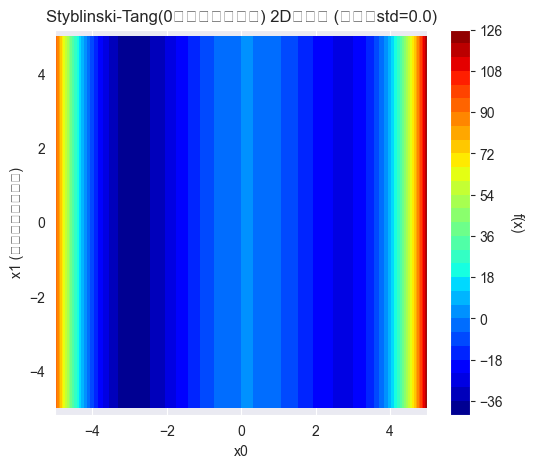

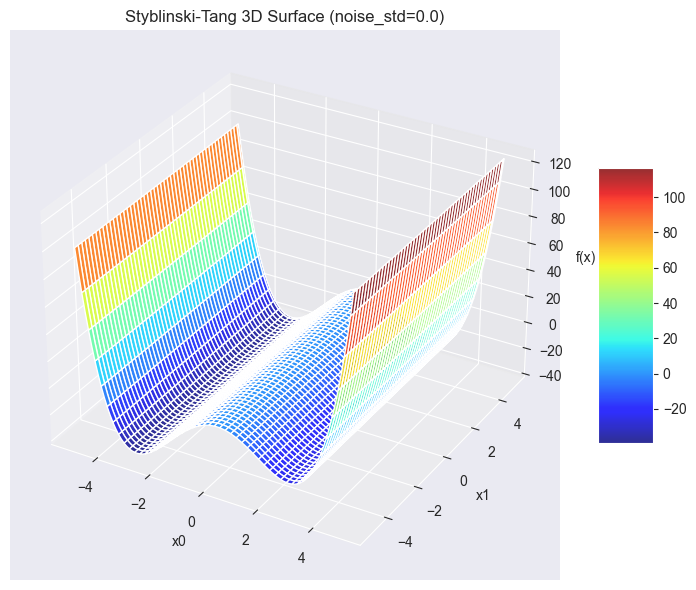

  0%|          | 0/5 [elapsed: 00:00 remaining: ?]

In [86]:
if __name__ == "__main__":
    # パラメータ設定
    dim = 2
    bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
    n_initial = 10   # 初期サンプル数 (必要に応じて変更)
    n_iter = 50      # BOイテレーション数 (必要に応じて変更)
    n_runs = 5       # 複数回の試行回数 (必要に応じて変更)

    # まず Styblinski-Tang関数(0次元目依存)を可視化
    plot_styblinski_tang_2d(bounds=(-5,5), N=100, noise_std=0.0)
    plot_styblinski_tang_3d(bounds=(-5,5), N=100, noise_std=0.0)

    # 実験
    eci_bo_bandit_history = []
    arm_selection_history = []
    bandit_list = []

    # tqdm での進捗表示(メモ: Jupyter の場合 tqdm.notebook.tqdm 推奨)
    try:
        with tqdm.notebook.tqdm(total=n_runs, bar_format=TQDM_BAR_FORMAT) as pbar:
            with io.capture_output() as captured:
                for run in range(n_runs):
                    X_init = generate_initial_points(n_initial, dim, bounds)
                    # ECI_BO_Bandit インスタンス
                    eci_bo_bandit = ECI_BO_Bandit(
                        X_init,
                        objective_function=styblinski_tang,  # 目的関数をstyblinski_tangに
                        bounds=bounds,
                        n_initial=n_initial,
                        n_max=n_iter,
                        dim=dim
                    )
                    best_x, best_f = eci_bo_bandit.optimize()

                    # 各試行の評価履歴を保存
                    eci_bo_bandit_history.append(eci_bo_bandit.eval_history)
                    arm_selection_history.append(eci_bo_bandit.arm_selection_history)
                    bandit_list.append(eci_bo_bandit)

                    pbar.update(1)  # 1試行終わるごとに進捗1追加

    except subprocess.CalledProcessError:
        print(captured)
        raise

    # すべての試行の平均履歴を計算
    eci_bo_bandit_history_average = np.mean(eci_bo_bandit_history, axis=0)

# 8. 結果の可視化 (収束プロットなど)

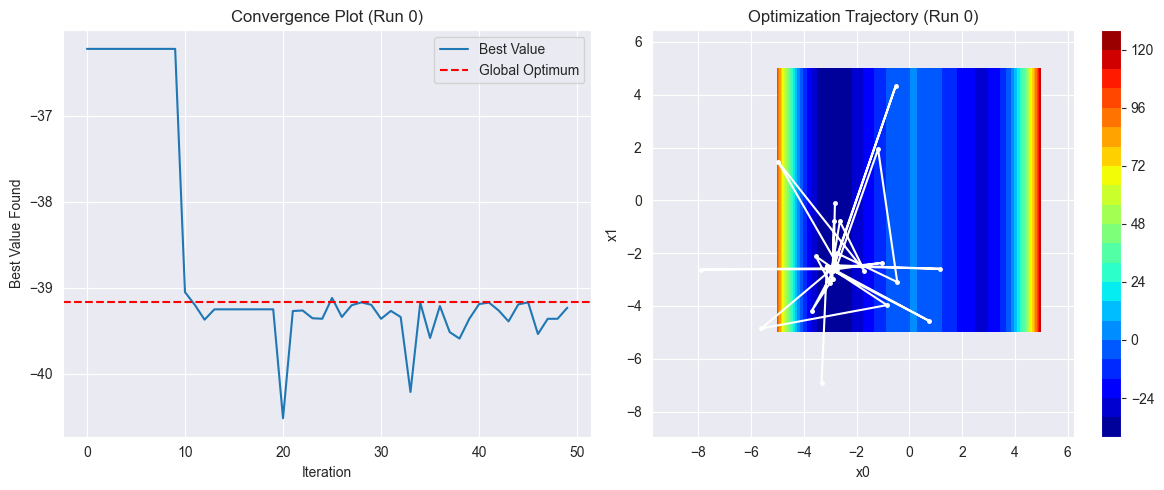

In [87]:
  def plot_optimization_trajectory(bandit, run_index=0):
        """
        指定した run の探索軌跡を 2D 上で可視化。
        """
        # 2D可視化用
        N = 100
        x_lin = np.linspace(bounds[0, 0].item(), bounds[1, 0].item(), N)
        y_lin = np.linspace(bounds[0, 1].item(), bounds[1, 1].item(), N)
        X_grid, Y_grid = np.meshgrid(x_lin, y_lin)

        # (N^2, 2) の配列へ
        xy = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
        xy_t = torch.tensor(xy, dtype=torch.float32)

        # ノイズなしで計算
        Z = styblinski_tang(xy_t, noise_std=0.0).reshape(N, N).detach().numpy()

        plt.figure(figsize=(12, 5))

        # 収束プロット
        plt.subplot(1, 2, 1)
        plt.plot(bandit.eval_history, label="Best Value")
        plt.axhline(y=global_optimum, color='r', linestyle='--', label='Global Optimum')
        plt.xlabel('Iteration')
        plt.ylabel('Best Value Found')
        plt.legend()
        plt.title('Convergence Plot (Run {})'.format(run_index))

        # 探索の軌跡プロット
        plt.subplot(1, 2, 2)
        cs = plt.contourf(X_grid, Y_grid, Z, levels=20, cmap='jet')
        plt.colorbar(cs)
        plt.title('Optimization Trajectory (Run {})'.format(run_index))
        plt.xlabel("x0")
        plt.ylabel("x1")
        plt.axis("equal")

        # 実際に探索した点(最適化ループ中に追加された点)
        points = torch.stack(bandit.optimization_history).detach().numpy()
        plt.plot(points[:,0], points[:,1], 'w.-', markersize=5)

        plt.tight_layout()
        plt.show()

    # 1つめの run の結果例を表示
if len(bandit_list) > 0:
    plot_optimization_trajectory(bandit_list[0], run_index=0)


# 9. 全試行まとめ(平均+1σ/-1σ表示)

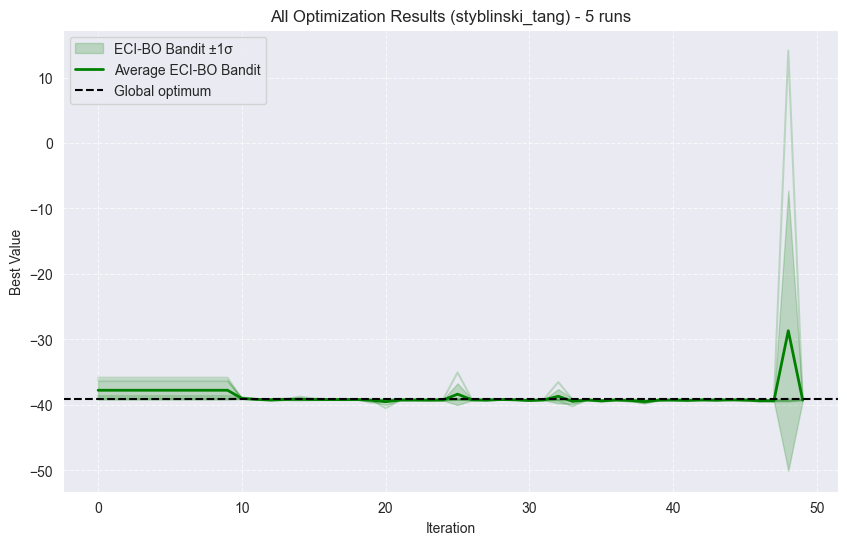

In [88]:
def calculate_confidence_bands(histories):
        histories_array = np.array(histories)
        mean = np.mean(histories_array, axis=0)
        std = np.std(histories_array, axis=0)
        return mean, mean - std, mean + std

mean_bandit, lower_bandit, upper_bandit = calculate_confidence_bands(eci_bo_bandit_history)

plt.figure(figsize=(10, 6))
# 個別の試行(薄い線で)
for history in eci_bo_bandit_history:
    plt.plot(history, color='green', alpha=0.2)
# 平均 + 1σバンド
plt.fill_between(range(len(mean_bandit)), lower_bandit, upper_bandit,
                 color='green', alpha=0.2, label='ECI-BO Bandit ±1σ')
plt.plot(mean_bandit, label="Average ECI-BO Bandit", color='green', linewidth=2)

# Global optimum
plt.axhline(global_optimum, color="black", linestyle="--", label="Global optimum", linewidth=1.5)

plt.xlabel("Iteration")
plt.ylabel("Best Value")
plt.title(f"All Optimization Results (styblinski_tang) - {n_runs} runs")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# 10. 選択したベクトル(direction) の集計・可視化(棒グラフ)

   - ここでは、各 run について、最終的に合計された direction_sum を描画してみる
   - dim=2 なので、2本の棒で (sum_of_dim0, sum_of_dim1) を表示

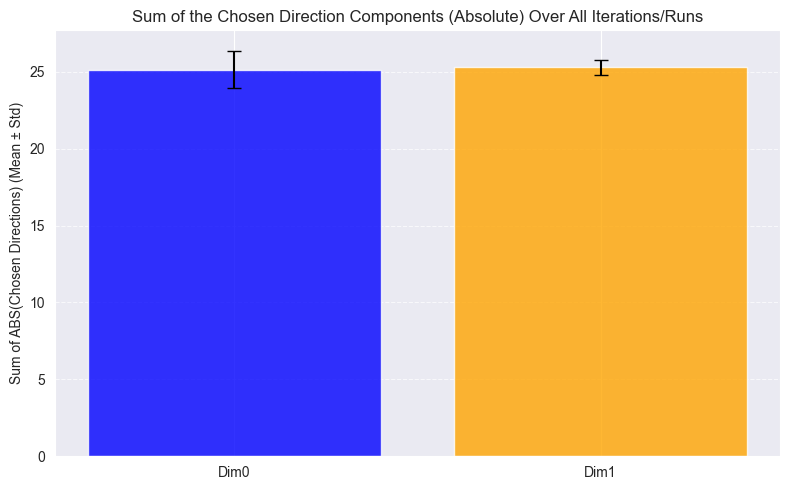

=== direction_sums_abs (each run) ===
Run 0: Dim0=26.360, Dim1=24.584
Run 1: Dim0=25.230, Dim1=25.818
Run 2: Dim0=22.810, Dim1=24.994
Run 3: Dim0=25.451, Dim1=25.221
Run 4: Dim0=25.853, Dim1=25.835


In [89]:
direction_sums_abs = [b.direction_sum_abs.detach().numpy() for b in bandit_list]
direction_sums_abs = np.array(direction_sums_abs)  # shape (n_runs, 2)

mean_dir_abs = np.mean(direction_sums_abs, axis=0)
std_dir_abs  = np.std(direction_sums_abs, axis=0)

x_labels = ["Dim0", "Dim1"]
x_pos = np.arange(len(x_labels))

plt.figure(figsize=(8, 5))
plt.bar(x_pos, mean_dir_abs, yerr=std_dir_abs, alpha=0.8, capsize=5, color=['blue','orange'])
plt.xticks(x_pos, x_labels)
plt.ylabel("Sum of ABS(Chosen Directions) (Mean ± Std)")
plt.title("Sum of the Chosen Direction Components (Absolute) Over All Iterations/Runs")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 各 run 毎の値をテーブル表示
print("=== direction_sums_abs (each run) ===")
for i, ds in enumerate(direction_sums_abs):
    print(f"Run {i}: Dim0={ds[0]:.3f}, Dim1={ds[1]:.3f}")